In [1]:
import matplotlib.pyplot as plt
from itertools import product
import slycot as sly
import numpy as np
import control as ct
import rpc_diism.robust as rb
s= ct.tf('s')

In [2]:
def step_opposite(g, t):
    # Compute reponse to step of [1,-1] of a system with 2 inputs and 2 outputs
    _, yu1 = ct.step_response(g, t, input=0, squeeze=True)
    _, yu2 = ct.step_response(g, t, input=1, squeeze=True)
    return yu1 - yu2


def plot_performance(w, P, K, S, We, Wu, g):
    
    I = ct.ss([], [], [], np.eye(2)) # Identity system
    
    gamma = g 
        
    # Compute singular values of S
    Ssv = rb.sigma(S, w)
    
    # Compute singular values of gamma*inv(We)
    Weinv = rb.invss(ct.ss(We))
    Weinvsv = rb.sigma(Weinv, w) * gamma
    
    # Compute input sensitivity
    KS = K*S
    
    # Compute singular values of KS
    KSsv = rb.sigma(KS, w)
    
    # Compute singular values of gamma*inv(Wu)
    Wuinv = rb.invss(ct.ss(Wu))
    Wuinvsv = rb.sigma(Wuinv, w) * gamma
    
    #a = np.where(w <= 0.11)[-1][-1]
    #b = np.where(w <= 200)[-1][-1]

    plt.figure(figsize=(15, 6))
    
    # First subplot
    plt.subplot(1, 3, 1)
    plt.semilogx(w, 20*np.log10(Ssv[:, 0]), 'm', label=r'$\sigma_1(S)$')
    plt.semilogx(w, 20*np.log10(Ssv[:, 1]), 'g', label=r'$\sigma_2(S)$')
    plt.semilogx(w, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\gamma \sigma_1({Ws_1}^{-1})$')
    plt.semilogx(w, 20*np.log10(Weinvsv[:, 1]), 'g:', label=r'$\gamma \sigma_2({Ws_1}^{-1})$')
    plt.ylabel('magnitude [dB]')
    plt.xlim([1e-3, 1e3])
    plt.xlabel('freq [rad/s]')
    plt.legend()
    plt.title('Singular values of S vs. gamma*inv(We)')
    
    #print('at w =', np.round(w[a], 3), '-->', 20*np.log10(Ssv[a,:]))
    
    plt.fill_between(w, -20, -200, where=(w <= 0.1), color='c', alpha=0.2)
    
    plt.ylim([-50, 20])
    # Second subplot
    plt.subplot(1, 3, 2)
    
    
    plt.semilogx(w, 20*np.log10(KSsv[:, 0]), 'm', label=r'$\sigma_1(KS)$')
    plt.semilogx(w, 20*np.log10(KSsv[:, 1]), 'g', label=r'$\sigma_2(KS)$')
    plt.semilogx(w, 20*np.log10(Wuinvsv[:, 0]), 'm:', label=r'$\gamma \sigma_1({Wu}^{-1})$')
    plt.semilogx(w, 20*np.log10(Wuinvsv[:, 1]), 'g:', label=r'$\gamma \sigma_2({Wu}^{-1})$')
    plt.ylabel('magnitude [dB]')
    plt.xlim([1e-3, 1e3])
    plt.xlabel('freq [rad/s]')
    plt.legend()
    plt.title('Singular values of KS vs. gamma*inv(Wu)')

    plt.fill_between(w, -10, -200, where=(w > 200), color='c', alpha=0.2)
    plt.ylim([-70, 30])
    
    #print('at w =', np.round((w[b]+w[b+1]) / 2, 3) , '-->', 20*np.log10(KSsv[b,:]))
    
    # Third subplot
    plt.subplot(1, 3, 3)
    t = np.linspace(0, 10, 101)
    
    T = (ct.ss(P*K)).feedback(I)
    
    '''K.input_labels = ['y[0]','y[1]']
    K.output_labels = ['u[0]','u[1]']
    
    T = ct.minreal(ct.interconnect([P, K, We, Wu, sum_n, sum_d, fbk],
                        inputs=['r[0]','r[1]'],
                        outputs=['y[0]','y[1]'],
                        check_unused=False),
                        verbose = False)'''
    
    y = step_opposite(T,t)
    c = np.round(y[0][-1],4)
    d = np.round(y[1][-1],4)
    
    plt.plot(t, y[0], 'b', label= f' $ y_1$ at steady state = {c}' )
    plt.plot(t, y[1], 'r', label= f' $ y_2$ at steady state = {d}')
    plt.xlabel('time')
    plt.ylabel('outputs')
    plt.legend()
    plt.title('Open loop response to input [1,-1]')
    plt.xlim([0, 10])
    #print(c)
    #print(d)
    plt.tight_layout()
    plt.show()


def plot_monte_carlo(Kr, We, Wu, w, taumin1, taumax1, taumin2, taumax2, gainmin1, gainmax1, gainmin2, gainmax2, best_mu_upper_bound):
    plt.figure(figsize=(15, 6))
    C = []
    D = []
    omega = w
    for i in range(1000):
        t_1 = np.round(np.random.uniform(taumin1,taumax1),5)
        t_2 = np.round(np.random.uniform(taumin2,taumax2),5)
        k_1 = np.round(np.random.uniform(gainmin1,gainmax1),5)
        k_2 = np.round(np.random.uniform(gainmin2,gainmax2),5)
        
        Pp = ct.tf([[[k_1],[-0.05]],
               [[0.1],[-k_2]]],
              [[[t_1, 1],[0.1, 1]],
               [[0.3, 1],[t_2, 1]]])
    
        # Compute sensitivity
        I = ct.ss([], [], [], np.eye(2)) # Identity system
        S_ = ct.feedback(I,Pp*Kr)
    
        # Compute singular values of S
        S_sv = mysigma(S_, w)
        # Compute singular values of KS
        KS_sv = mysigma(Kr*S_, w) 
    
        T = (ct.ss(Pp*Kr)).feedback(I)
    
        t = np.linspace(0, 10, 101)
        y = step_opposite(T,t)
        c = np.round(y[0][-1],4)
        d = np.round(y[1][-1],4)
    
        C.append(c)
        D.append(d)
        
        plt.subplot(1, 3, 1)
        plt.semilogx(w, 20*np.log10(S_sv[:, 0]), 'm')
        plt.semilogx(w, 20*np.log10(S_sv[:, 1]), 'g')
    
        plt.subplot(1, 3, 2)
        plt.semilogx(w, 20*np.log10(KS_sv[:, 0]), 'm')
        plt.semilogx(w, 20*np.log10(KS_sv[:, 1]), 'g')
    
        plt.subplot(1, 3, 3)
        plt.plot(t, y[0], 'b')
        plt.plot(t, y[1], 'r')
    
    Wuinv = rb.invss(ct.ss(Wu))
    Wuinvsv = rb.sigma(Wuinv, omega) * best_mu_upper_bound
    Weinv = rb.invss(ct.ss(We))  
    Weinvsv = rb.sigma(Weinv, omega) * best_mu_upper_bound
    
    
    plt.subplot(1, 3, 1)
    plt.fill_between(w, -20, -200, where=(w <= 0.1), color='c', alpha=0.2)
    plt.semilogx(w, 20*np.log10(Weinvsv[:, 0]), 'm:')
    plt.semilogx(w, 20*np.log10(Weinvsv[:, 1]), 'g:')
    plt.title('Singular values of S')
    plt.ylim([-60, 10])
    plt.ylabel('magnitude [dB]')
    plt.xlim([1e-3, 1e3])
    plt.xlabel('freq [rad/s]')

    
    plt.subplot(1, 3, 2)
    plt.fill_between(w, -10, -200, where=(w > 200), color='c', alpha=0.2)
    plt.ylim([-70, 20])
    plt.semilogx(w, 20*np.log10(Wuinvsv[:, 0]), 'm:')
    plt.semilogx(w, 20*np.log10(Wuinvsv[:, 1]), 'g:')
    plt.title('Singular values of KS')
    plt.ylabel('magnitude [dB]')
    plt.xlim([1e-3, 1e3])
    plt.xlabel('freq [rad/s]')
    
    
    plt.subplot(1, 3, 3)
    plt.xlabel('time')
    plt.ylabel('outputs')
    
    plt.title('Open loop response to input [1,-1]')
    #plt.xlim([0, 10])
    plt.tight_layout()
    plt.show()
    
    male = False
    for i in range(len(C)):
        if C[i] >= 1-1e-3 and C[i] <= 1+1e-3 and D[i] >= -1-1e-3 and D[i] <= -1+1e-3:
            j = 0
        else:
            male = True
    if not male:
        print('No simulation excede the error of 0.001')
    else:
        print('-- Max error exceded --')

Main program

In [3]:
# Plant P
k10=12
k20=5
k1max=1.15*k10
k1min=0.85*k10
k2max=1.15*k20
k2min=0.85*k20
T10=0.2
T20=0.7
T1max=T10*1.2
T1min=T10*0.8
T2max=T20*1.2
T2min=T20*0.8
alpha1 = (k1max-k1min)/2/k10
alpha3 = (k2max-k2min)/2/k20
alpha2 = (T1max-T1min)/2/T10
alpha4 = (T2max-T2min)/2/T20

P21=ct.tf([0.1],[0.3,1],inputs='u[0]',outputs='y21')
P12=ct.tf([-0.05],[0.1,1],inputs='u[1]',outputs='y12')

K1 = ct.ss([],[],[],k10, inputs='u[0]',outputs='q1')
K2 = ct.ss([],[],[],k20, inputs='u[1]',outputs='q3')
A1 = ct.ss([],[],[],alpha1, inputs='q1',outputs='zdelta[0]')
A3 = ct.ss([],[],[],alpha3, inputs='q3',outputs='zdelta[2]')

W2 = ct.tf([alpha2*T10,0.0],[T10,1], inputs='y11',outputs='zdelta[1]')
W4 = ct.tf([alpha4*T20,0.0],[T20,1], inputs='y22',outputs='zdelta[3]')

sump2 = ct.summing_junction(inputs=['wdelta[0]','q1'], output='p2')
sump4 = ct.summing_junction(inputs=['wdelta[2]','q3'], output='p4')

P11=ct.tf([1],[T10,1],inputs='p2',outputs='q2')
P22=ct.tf([-1],[T20,1],inputs='p4',outputs='q4')

sumy11 = ct.summing_junction(inputs=['q2','wdelta[1]'], output='y11')
sumy22 = ct.summing_junction(inputs=['q4','wdelta[3]'], output='y22')

sumy1 = ct.summing_junction(inputs=['y11','y12'], output='y[0]')
sumy2 = ct.summing_junction(inputs=['y21','y22'], output='y[1]')

sumnoise = ct.summing_junction(inputs=['y','n'], output='ybar', dimension=2)

# Feedback: y = r-y
fbk = ct.summing_junction(inputs=['r','-ybar'], output='e', dimension=2)

# Performance weight We (weight on S)
M = 3
e = 1e-4
wb = 1 # Crossover frequency
We_1 = ct.ss(rb.weightS(wb, M, e, 1))
We = We_1.append(We_1)
We.input_labels = ['e[0]', 'e[1]']
We.output_labels = ['z[0]', 'z[1]']

# Weight on command input
Mu = 0.62
eu = 1e-4
wbc = 2*np.pi*10
Wu11 = ct.ss(rb.weightU(wbc, Mu, eu, 1))
Wu = Wu11.append(Wu11)
Wu.input_labels = ['u[0]', 'u[1]']
Wu.output_labels = ['z[2]', 'z[3]']

G = ct.minreal(ct.interconnect([P21, P12, K1, K2, A1, A3, W2,
                                W4, sump2, sump4, P11, P22, sumy11, sumy22,
                                sumy1, sumy2, We, Wu, fbk, sumnoise],
                    inputs=['wdelta[0]','wdelta[1]','wdelta[2]','wdelta[3]','r[0]','r[1]','n[0]','n[1]','u[0]','u[1]'],
                    outputs=['zdelta[0]','zdelta[1]','zdelta[2]','zdelta[3]','z[0]','z[1]','z[2]','z[3]','e[0]','e[1]']), 
                    verbose=False)


Construct the LFT

Do $\mu$-synthesis. Observe that in order to get guaranteed robust performance $\|T_{zw}\|_\infty\leq 1$ with respect to a pre-specified uncertainty set $\|\Delta\|_\infty<1$, the obtained value of $\bar\mu$ must be less than 1. Otherwise, only a scaled performance $\|T_{zw}\|_\infty\leq \bar\mu$ for $\|\Delta\|_\infty<1/\bar\mu$ is guaranteed. This may be unacceptable if the uncertainty set is fixed a-priori. In this case, the only thing to do is relax the performance requirement.

In [4]:
# Controller I/O sizes
f = 2

# Uncertainty structure: four 1x1 uncertainty blocks and a 4x4 performance block
nblock = np.array([1,1,1,1,4])
# This has to be == 2 (complex uncertainty) for each block (other values are not implemented)
itype = np.array([2,2,2,2,2])

# Frequency range for mu computations
omega = np.logspace(-3, 3, 101)

# Do mu-synthesis via D-K iteration
K, best_mu_upper_bound, init_mubar, best_mubar, gamma = rb.musyn(G, f, nblock, itype, omega, reduce=0, initgamma=10)

display("Best mu upper bound: ", best_mu_upper_bound)

Infinity norm of Tzw_delta with initial Hinfinity controller:  1.1374530437213473
Iteration # 1
Best upper bound to mu norm of Tzw_delta:  1.0423166926042697
Iteration # 2
Best upper bound to mu norm of Tzw_delta:  1.0007804436437169
Iteration # 3
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  2
Iteration # 4
Best upper bound to mu norm of Tzw_delta:  1.000653060252917
Iteration # 5
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  2
Iteration # 6
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  3
Iteration # 7
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  4
Iteration # 8
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  1
Iteration # 9
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  2
Iteration # 10
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  3


'Best mu upper bound: '

1.000653060252917

Plot initial and final values of $\mu$ upper bound

Text(0.5, 1.0, 'Initial and final $\\bar\\mu$')

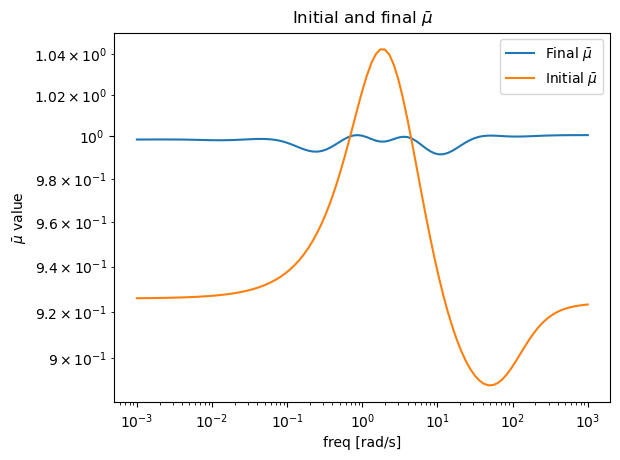

In [5]:
plt.loglog(omega, best_mubar, label=r'Final $\bar \mu$')
plt.loglog(omega, init_mubar, label=r'Initial $\bar \mu$')
plt.ylabel(r'$\bar\mu$ value')
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title(r'Initial and final $\bar\mu$')

Controller order reduction: perform a "balanced truncation" of the controller by removing almost uncontrollable or unobservable modes. Try reducing the order as long as the frequency response of the full and reduced controllers remain reasonably close. Then, evaluate the actual $\bar\mu$ achieved by the reduced controller.

Text(0.5, 1.0, 'Comparison of singular values of full and reduced $K$')

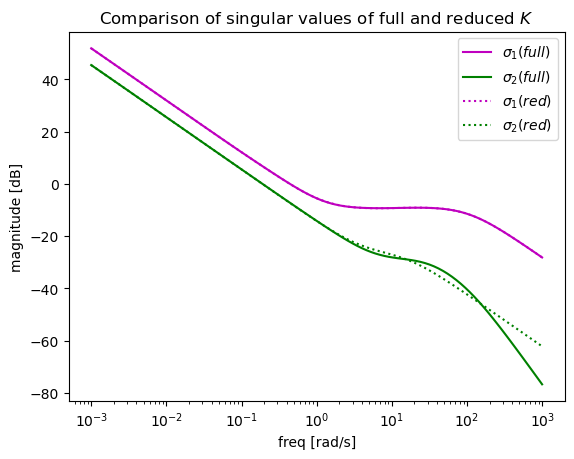

In [6]:
# Plot the frequency response of the controller
Ksv = rb.sigma(K, omega)
plt.semilogx(omega, 20*np.log10(Ksv[:, 0]), 'm', label=r'$\sigma_1(full)$')
plt.semilogx(omega, 20*np.log10(Ksv[:, 1]), 'g', label=r'$\sigma_2(full)$')

# Perform controller order reduction
order = 8
Kr = ct.balred(K, order, method='truncate')

# Plot the frequency response of the reduced controller
Krsv = rb.sigma(Kr, omega)
plt.semilogx(omega, 20*np.log10(Krsv[:, 0]), 'm:', label=r'$\sigma_1(red)$')
plt.semilogx(omega, 20*np.log10(Krsv[:, 1]), 'g:', label=r'$\sigma_2(red)$')
plt.ylabel('magnitude [dB]')
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title('Comparison of singular values of full and reduced $K$')

'Peak mu upper bound with reduced controller:'

1.0019652618535813

Text(0.5, 1.0, 'Full and reduced controller $\\bar\\mu$')

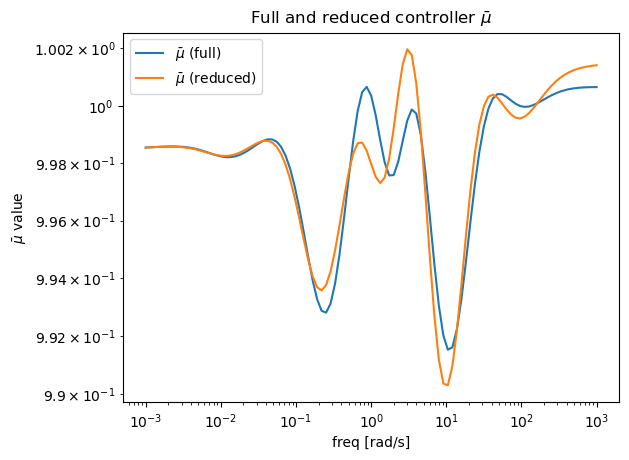

In [7]:
# After controller reduction, compute the actual mubar achieved by the reduced controller
# Generate the closed loop M transfer function for mu analysis
Kr.input_labels = ['e[0]','e[1]']
Kr.output_labels = ['u[0]','u[1]'] 
M = ct.minreal(ct.interconnect([P21, P12, K1, K2, A1, A3, W2,
                                W4, sump2, sump4, P11, P22, sumy11, sumy22,
                                sumy1, sumy2, We, Wu, fbk, sumnoise, Kr],
                    inputs=['wdelta[0]','wdelta[1]','wdelta[2]','wdelta[3]','r[0]','r[1]','n[0]','n[1]'],
                    outputs=['zdelta[0]','zdelta[1]','zdelta[2]','zdelta[3]','z[0]','z[1]','z[2]','z[3]'],
                    check_unused=False), 
                    verbose=False)

# Compute actual mu upper bound (frequency peak) for reduced controller
red_mubar, red_mubar_p = rb.mucomp(M, nblock, itype, omega)
display("Peak mu upper bound with reduced controller:", red_mubar_p)

# Plot the mu upper bound for full and reduced controller
plt.loglog(omega, best_mubar, label=r'$\bar \mu$ (full)')
plt.loglog(omega, red_mubar, label=r'$\bar \mu$ (reduced)')
plt.ylabel(r'$\bar\mu$ value')
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title(r'Full and reduced controller $\bar\mu$')

Verify performance on the nominal system. It must hold that $\|W_e S\|_\infty \leq \gamma$ for $\gamma=\sup_\omega \bar\mu$. 

0 states have been removed from the model


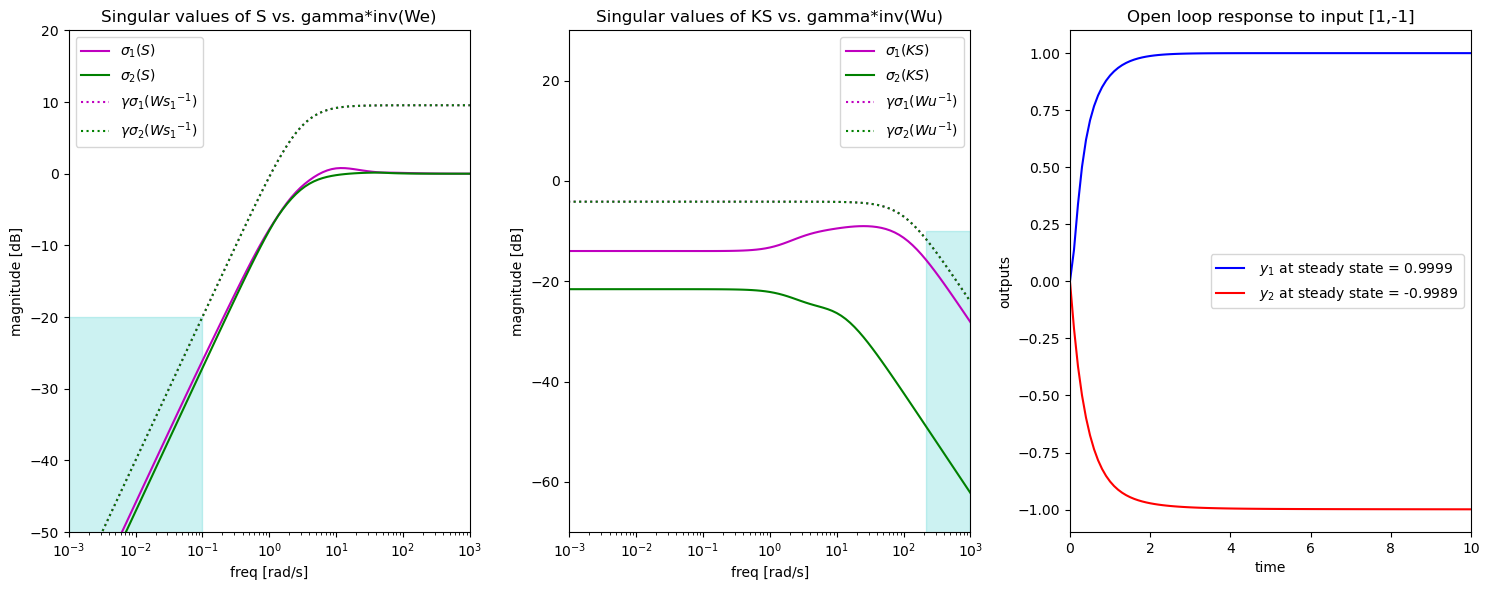

In [8]:
# Compute closed loop sensitivity for the nominal system
I = ct.ss([], [], [], np.eye(2)) # Identity system  

# Perturbed plant
P = ct.tf([[[k10], [-0.05]],
              [[0.1], [-k20]]],
             [[[T10,1], [0.1,1]],
              [[0.3,1], [T20,1]]])


S = ct.minreal(ct.feedback(I,P*Kr))

# Frequency range for mu computations
omega = np.logspace(-5, 3, 121)



plot_performance(omega, P, Kr, S, We, Wu, best_mu_upper_bound)

Text(0.5, 1.0, 'Singular values of S vs. gamma*inv(We) for the nominal system')

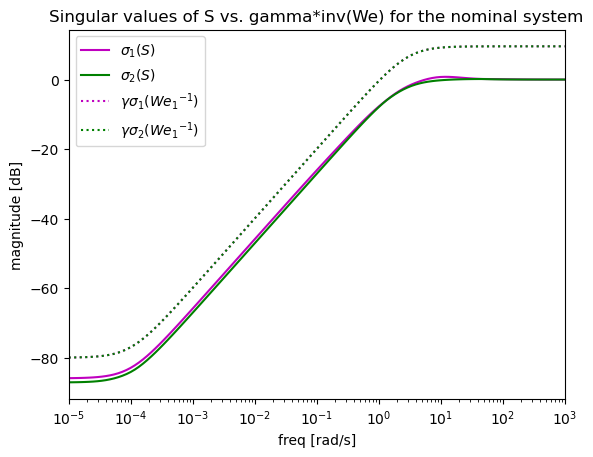

In [9]:
# Compute singular values of S over frequency
Ssv = rb.sigma(S, omega)

# We plot the singular values of gamma*invss(We) along with S
# for gamma = best_mu_upper_bound
Weinv = rb.invss(We)
Weinvsv = rb.sigma(Weinv, omega) * red_mubar_p
Wuinv = rb.invss(Wu)
Wuinvsv = rb.sigma(Wuinv, omega) * red_mubar_p

plt.semilogx(omega, 20*np.log10(Ssv[:, 0]), 'm', label=r'$\sigma_1(S)$')
plt.semilogx(omega, 20*np.log10(Ssv[:, 1]), 'g', label=r'$\sigma_2(S)$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\gamma \sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 1]), 'g:', label=r'$\gamma \sigma_2({We_1}^{-1})$')
#plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-5, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title('Singular values of S vs. gamma*inv(We) for the nominal system')

array([-7.21360343e+07+0.00000000e+00j, -5.89723388e+02+0.00000000e+00j,
       -1.04178916e+02+0.00000000e+00j, -1.04857814e+02+0.00000000e+00j,
       -1.07005263e+02+0.00000000e+00j, -1.06917752e+02+8.76829468e-02j,
       -1.06917752e+02-8.76829468e-02j, -1.06938475e+02+0.00000000e+00j,
       -1.06907260e+02+1.81054869e-02j, -1.06907260e+02-1.81054869e-02j,
       -1.06829893e+02+0.00000000e+00j, -1.06541311e+02+0.00000000e+00j,
       -3.11731717e+01+0.00000000e+00j, -1.98300163e+01+0.00000000e+00j,
       -1.84315544e+01+0.00000000e+00j, -1.60436172e+01+1.19221942e-01j,
       -1.60436172e+01-1.19221942e-01j, -1.60890683e+01+0.00000000e+00j,
       -1.58201833e+01+2.23742470e-01j, -1.58201833e+01-2.23742470e-01j,
       -1.57409621e+01+1.99397522e-01j, -1.57409621e+01-1.99397522e-01j,
       -1.32986150e+01+3.49903586e-01j, -1.32986150e+01-3.49903586e-01j,
       -1.35290809e+01+1.78606123e-01j, -1.35290809e+01-1.78606123e-01j,
       -1.40075297e+01+4.56411415e-01j, -1.40075297

Text(0.5, 1.0, 'Singular values of KS vs. gamma*inv(Wu) for the nominal system')

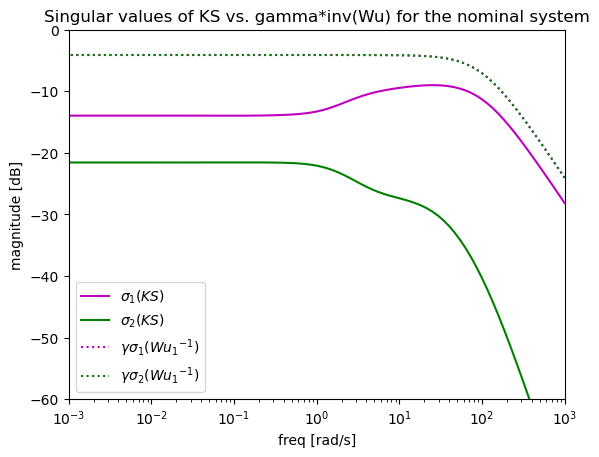

In [10]:
# Input sensitivity
KS = K*S
display(ct.poles(KS))

# Compute singular values of S over frequency
KSsv = rb.sigma(KS, omega)

plt.semilogx(omega, 20*np.log10(KSsv[:, 0]), 'm', label=r'$\sigma_1(KS)$')
plt.semilogx(omega, 20*np.log10(KSsv[:, 1]), 'g', label=r'$\sigma_2(KS)$')
plt.semilogx(omega, 20*np.log10(Wuinvsv[:, 0]), 'm:', label=r'$\gamma \sigma_1({Wu_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(Wuinvsv[:, 1]), 'g:', label=r'$\gamma \sigma_2({Wu_1}^{-1})$')
plt.ylim([-60, 0])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title('Singular values of KS vs. gamma*inv(Wu) for the nominal system')


array([-1.04178917e+02+0.j, -1.40236423e+01+0.j, -1.08529469e+01+0.j,
       -9.96949147e+00+0.j, -8.05387011e+00+0.j, -3.33099986e+00+0.j,
       -2.63741916e+00+0.j, -1.13382387e+00+0.j, -2.08042140e+00+0.j,
       -1.48926568e-01+0.j, -8.25465758e-03+0.j, -1.25497973e-02+0.j])

Text(0.5, 1.0, 'Singular values of T vs.  for the nominal system')

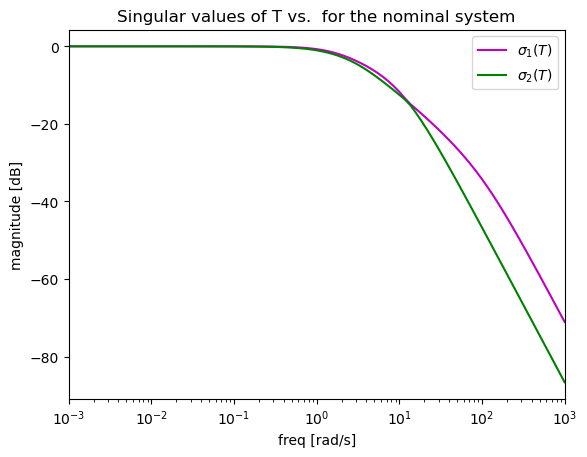

In [11]:
# Complementary sensitivity
T = (ct.ss(P)*Kr).feedback(I)
display(ct.poles(T))


# Compute singular values of S over frequency
Tsv = rb.sigma(T, omega)

plt.semilogx(omega, 20*np.log10(Tsv[:, 0]), 'm', label=r'$\sigma_1(T)$')
plt.semilogx(omega, 20*np.log10(Tsv[:, 1]), 'g', label=r'$\sigma_2(T)$')
#plt.ylim([-60, 0])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title('Singular values of T vs.  for the nominal system')

Text(0.5, 1.0, 'Closed loop response to reference [1,-1]')

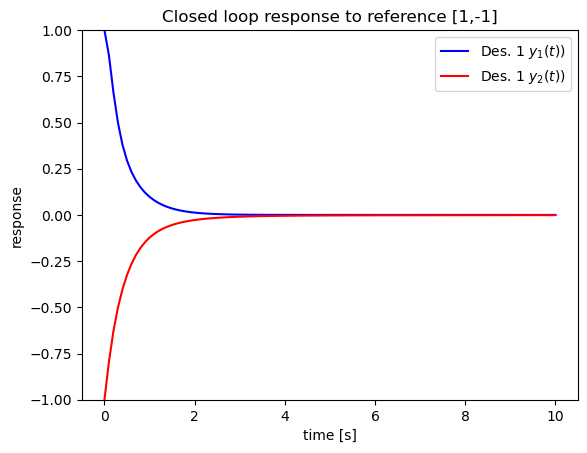

In [12]:
time = np.linspace(0, 10, 101)

y_1 = step_opposite(T, time)

plt.plot(time, 1-y_1[0], 'b', label='Des. 1 $y_1(t))$')
plt.plot(time, -1-y_1[1], 'r', label='Des. 1 $y_2(t))$')
plt.xlabel('time [s]')
plt.ylabel('response')
plt.ylim([-1, 1])
plt.legend()
plt.title('Closed loop response to reference [1,-1]')